In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from molecular_mpns.config import fig_dir
import os
import seaborn as sns
os.chdir(fig_dir)

In [5]:
# define double well system
class DoubleWell:
    
    def __init__(self,a=0.25,b=3,c=1,d=0.5):
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        
    
    def U(self,x):
        return self.a*x[0,:]**4 - self.b*x[0,:]**2 + self.c*x[0,:] + self.d*x[1,:]**2
    
    def gradU(self,x):
        return np.vstack([4*self.a*x[0,:]**3 - 2*self.b*x[0,:] + self.c,2*self.d*x[1,:]])
    

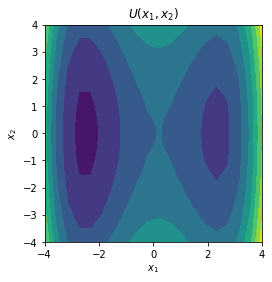

In [11]:
# visualize potential
system = DoubleWell()

lin = np.linspace(-4,4,20)
X,Y = np.meshgrid(lin,lin)
XY = np.vstack([X.flatten(),Y.flatten()])
U = system.U(XY)

plt.contourf(X,Y,U.reshape(X.shape))
plt.gca().set_aspect('equal')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'$U(x_1,x_2)$')
plt.savefig('vae_dbl_well.png')
plt.show()
plt.close()

In [12]:
# define model

class Encoder(torch.nn.Module):
    
    def __init__(self,d1,d2,d3,d_x = 2,d_z=1):
        super(Encoder,self).__init__()
        
        self.lin1 = torch.nn.Linear(d_x,d1)
        self.lin2 = torch.nn.Linear(d1,d2)
        self.lin3 = torch.nn.Linear(d2,d3)
        self.mu = torch.nn.Linear(d3,d_z)
        self.logvar = torch.nn.Linear(d3,d_z)
        
    def forward(self,X):
        
        h = self.lin1(X)
        h = torch.nn.functional.selu(h)
        h = self.lin2(h)
        h = torch.nn.functional.selu(h)
        h = self.lin3(h)
        h = torch.tanh(h)
        
        mu = self.mu(h)
        logvar = self.logvar(h)
        
        return mu , logvar
    
class Decoder(torch.nn.Module):
    
    def __init__(self,d1,d2,d_z = 1,d_x = 2):
        super(Decoder,self).__init__()
        
        self.lin1 = torch.nn.Linear(d_z,d1)
        self.lin2 = torch.nn.Linear(d1,d2)
        
        self.mu = torch.nn.Linear(d2,d_x)
        self.register_parameter(name='logvar', param=torch.nn.Parameter(torch.randn(d_x)))
        
    def forward(self,Z):
        
        h = self.lin1(Z)
        h = torch.tanh(h)
        h = self.lin2(h)
        h = torch.tanh(h)
        
        mu = self.mu(h)
        sig = torch.exp(0.5*self.logvar)
        
        eps = torch.randn_like(mu)
        X = mu + sig*eps
        
        return X , mu

In [13]:
# build model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
d1,d2,d3,d_z = 100,100,100,1
Z = torch.randn(3,1)
encoder = Encoder(d1,d2,d3).to(device)
decoder = Decoder(d1,d2).to(device)

opt_enc = torch.optim.Adam(encoder.parameters(),lr = 1e-4)
opt_dec = torch.optim.Adam(decoder.parameters(),lr = 1e-4)


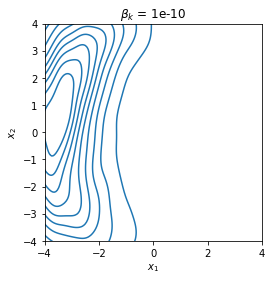

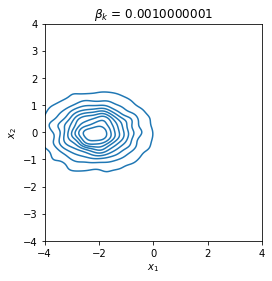

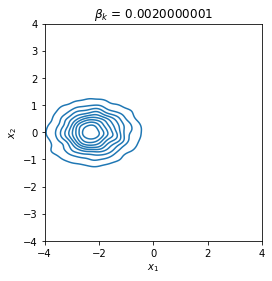

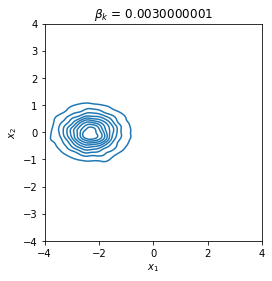

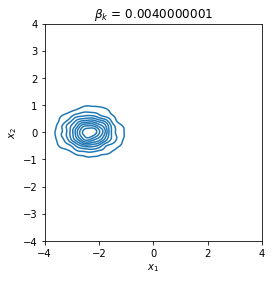

KeyboardInterrupt: 

In [14]:
# train
c_max, dbeta = 1,1e-3
beta_start = 1e-10
beta_k = beta_start
beta_target = 1
epochs,batch_size = 3000,1028
s=0


while beta_k < beta_target:
    for ep in range(epochs):
        Z = torch.randn(batch_size,d_z).to(device) # sample q(z)
        X,mu_X = decoder(Z) # sample q(x|z)
        mu_Z,logvar_Z = encoder(X) # compute components of log r(x|z)
        
        # force/potential calculation
        X_calc = X.cpu().detach().numpy()
        X_calc = X_calc.T # (bs,d_x) -> (d_x,bs) 
        U = system.U(X_calc) # (bs,)
        dU = system.gradU(X_calc) # (d_x,bs)
        dU = dU.T # (d_x,bs) -> (bs,d_x)
        
        # backward pass for physical component
        dU = torch.tensor(dU).to(device)
        X.backward(beta_k*dU,retain_graph = True)
        
        # backward pass for nonphysical component
        prec_Z = torch.exp(-logvar_Z)
        prec_X = torch.exp(-decoder.logvar)
        
        logrzx = -0.5*(Z-mu_Z)*(prec_Z)*(Z-mu_Z)
        logrzx = logrzx.sum(axis = 1) # add across dimensions to compute log likelihoods
        logrzx = logrzx.mean() # average log likelihood
        
        logqz = (-0.5*(Z*Z)).sum(axis = 1).mean()
        
        logqxz = -0.5*(X-mu_X)*(prec_X)*(X-mu_X)
        logqxz = logqxz.sum(axis = 1) # add across dimensions to compute log likelihoods
        logqxz = logqxz.mean() # average log likelihood
        
        nonphys_loss = -logrzx + logqz + logqxz
        nonphys_loss.backward()
        
        # update params
        opt_enc.step()
        opt_dec.step()
        opt_enc.zero_grad()
        opt_dec.zero_grad()
        
        # compute total loss
        #loss = beta_k*np.mean(U) + nonphys_loss.item()
        #print('Current inverse temp:' + str(beta_k) +' , Epoch ' + str(ep+1) + " Loss: " + str(loss))
    
    # ancestral sampling of current model
    Z = torch.randn(5000,d_z).to(device) 
    with torch.no_grad():
        X,_ = decoder(Z)
        mu_Z,_ = encoder(X)
    X = X.detach().cpu().numpy()
    mu_Z = mu_Z.detach().cpu().numpy()
    
    
    #plt.scatter(x = X[:,0],y = X[:,1], c = mu_Z)
    sns.kdeplot(x = X[:,0],y = X[:,1])
    plt.title(r'$\beta_k$' + " = " + str(beta_k))
    plt.xlim([-4,4])
    plt.ylim([-4,4])
    plt.gca().set_aspect('equal')
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.savefig('ancestral_vae'+ str(s) +'.png')
    plt.show()
    plt.close()
    
    # compute Z(beta_0)
    if beta_k == beta_start:
        Z_imp = torch.randn(batch_size,d_z).to(device)
        with torch.no_grad():
            X_imp,mu_X = decoder(Z_imp) # sample q(x|z)
            mu_Z,logvar_Z = encoder(X_imp) # compute components of log r(x|z)
        
            # potential calculation
            X_calc = X_imp.cpu().detach().numpy()
            X_calc = X_calc.T 
            U = system.U(X_calc) 
        
            # likelihood and entropy calculation
            prec_Z = torch.exp(-logvar_Z)
            prec_X = torch.exp(-decoder.logvar)
        
            logrzx = -0.5*(Z_imp-mu_Z)*(prec_Z)*(Z_imp-mu_Z)
            logrzx = logrzx.sum(axis = 1)
        
            logqz = (-0.5*(Z_imp*Z_imp)).sum(axis = 1)
        
            logqxz = -0.5*(X_imp-mu_X)*(prec_X)*(X_imp-mu_X)
            logqxz = logqxz.sum(axis = 1) 
        
            # compute log weights
            logw = -beta_k*U + logrzx.detach().cpu().numpy() - (logqz.detach().cpu().numpy() + logqxz.detach().cpu().numpy())
            c = logw.max()
        
            # compute log Z(beta_0)
            log_partition = -np.log(batch_size) + np.log(np.sum(np.exp(logw-c))) + c

        
    # update beta_k
    cs,fs = c_max+1,1
    while cs > c_max:
        beta_prop = beta_k+fs*dbeta
        
        # estimate KL increase
        Z_imp = torch.randn(batch_size,d_z).to(device)
        with torch.no_grad():
            X_imp,mu_X = decoder(Z_imp) # sample q(x|z)
            mu_Z,logvar_Z = encoder(X_imp) # compute components of log r(x|z)
        
            # potential calculation
            X_calc = X_imp.cpu().detach().numpy()
            X_calc = X_calc.T 
            U = system.U(X_calc) 
        
            # likelihood and entropy calculation
            prec_Z = torch.exp(-logvar_Z)
            prec_X = torch.exp(-decoder.logvar)
        
            logrzx = -0.5*(Z_imp-mu_Z)*(prec_Z)*(Z_imp-mu_Z)
            logrzx = logrzx.sum(axis = 1)
        
            logqz = (-0.5*(Z_imp*Z_imp)).sum(axis = 1)
        
            logqxz = -0.5*(X_imp-mu_X)*(prec_X)*(X_imp-mu_X)
            logqxz = logqxz.sum(axis = 1) 
        
            # compute log weights
            logw = -beta_k*U + logrzx.detach().cpu().numpy() - (logqz.detach().cpu().numpy() + logqxz.detach().cpu().numpy())
            c = logw.max()
        
        w = np.exp(logw-c)
        w_norm = w/w.sum()
        beta_diff = beta_prop - beta_k
        density_contrib = np.exp(-beta_diff*U)
        diff_log = np.log(np.sum(w_norm*density_contrib))
        
        cs = (diff_log + beta_diff*np.mean(U))/(log_partition - np.mean(logw))
        fs *= 0.6
    
    beta_k = beta_prop
    log_partition += diff_log
    s += 1
        
        